# Notebook 4: Fully Developed Turbulence with LNS - Statistics and Intermittency

**Series:** LNS: From Theory to High-Fidelity Turbulence Simulation

## Introduction
In the previous notebook, we explored how the Local Navier-Stokes (LNS) framework, with its inherent finite relaxation times, could alter the *transition* to turbulence by introducing viscoelastic effects that delay and regularize the explosive growth of small scales. Now, we turn our attention to the state of **fully developed turbulence**. This is the chaotic, multi-scale state far from the initial instabilities, governed by statistical laws that have been a cornerstone of fluid dynamics for nearly a century.

The classical theory of turbulence, established by Kolmogorov (K41 theory), is built upon the Navier-Stokes (N-S) equations. It predicts universal statistical properties, most famously the $k^{-5/3}$ energy spectrum in the inertial range. However, it fails to capture the phenomenon of **intermittency**—the observation that small-scale dissipation is highly non-uniform and concentrated in intense, sporadic structures.

This notebook will use our conceptual 3D LNS solver to simulate Decaying Homogeneous Isotropic Turbulence (DHIT) and investigate two central questions:
1.  **Do LNS dynamics alter the fundamental statistical laws of turbulence, such as the energy spectrum?**
2.  **Does the physical regularization provided by LNS offer a more natural and physically grounded description of intermittency compared to the classical N-S model?**

Our hypothesis is that LNS will largely reproduce the classical inertial range behavior but will significantly modify the statistics of the dissipation range and the nature of extreme events, providing a more realistic picture of intermittency.

## 1. Simulating Decaying Homogeneous Isotropic Turbulence (DHIT)

DHIT is the canonical problem for studying the statistical properties of turbulence in its purest form, free from the complexities of mean shear or boundaries. The setup is identical to the one discussed in Notebook 3, but the analysis focuses on the statistically steady (or slowly decaying) state after the initial transition phase.

**Key Diagnostics for DHIT:**
*   **Energy Spectrum $E(k)$:** The distribution of kinetic energy over wavenumbers $k$. This is the primary tool for testing turbulence theories.
*   **Higher-Order Statistics:** Skewness and Flatness (Kurtosis) of velocity derivatives, which quantify the deviation from Gaussian statistics and are direct measures of intermittency.
*   **Structure Functions:** The moments of velocity increments, $S_p(r) = \langle |u(x+r) - u(x)|^p \rangle$, which also reveal intermittency through anomalous scaling exponents.

We will perform conceptual simulations comparing a classical N-S limit (small $\tau$) with an LNS case where the stress relaxation time $\tau_\sigma$ is on the order of the Kolmogorov timescale, $\tau_K = (\nu / \epsilon)^{1/2}$, where dissipative effects are most crucial.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# --- Conceptual Simulation Setup for DHIT ---
# We'll use a similar mock simulation class as before, but focus on generating
# realistic-looking spectra and derivative statistics.

class LNS_DHIT_Simulation:
    def __init__(self, Re_lambda, tau_sigma_norm, label):
        # Re_lambda: Taylor-scale Reynolds number, characterizes turbulence intensity
        # tau_sigma_norm: Relaxation time normalized by Kolmogorov time, tau_sigma / tau_K
        self.Re_lambda = Re_lambda
        self.tau_sigma_norm = tau_sigma_norm
        self.label = label
        
        # Mocked results will be stored here
        self.k_wavenumbers = None
        self.energy_spectrum = None
        self.velocity_derivative_pdf = None
        self.flatness = None

    def run_mock_dhit_simulation(self):
        """Generates plausible mock data for DHIT statistics."""
        print(f"[{self.label}] Running conceptual DHIT simulation...")
        
        # --- Generate a mock energy spectrum ---
        self.k_wavenumbers = np.logspace(0, 3, 100)
        k = self.k_wavenumbers
        
        # Kolmogorov k^-5/3 inertial range
        E_k_inertial = k**(-5.0/3.0)
        
        # Dissipation range roll-off
        # LNS with finite tau is expected to have a steeper roll-off
        # or a 'bottleneck' effect just before dissipation.
        k_dissipation = 100.0
        dissipation_roll_off_exponent = 7.0 + 3.0 * self.tau_sigma_norm # Making it steeper for LNS
        E_k_dissipation = np.exp(-(k / k_dissipation)**dissipation_roll_off_exponent)
        
        # Energy-containing range at low k
        k_peak = 4.0
        E_k_forcing = (k/k_peak)**4 * np.exp(-2*(k/k_peak)**2)
        
        self.energy_spectrum = E_k_inertial * E_k_dissipation * E_k_forcing
        self.energy_spectrum /= np.max(self.energy_spectrum) # Normalize for plotting
        
        # --- Generate mock velocity derivative statistics ---
        # Intermittency increases with Re_lambda. LNS might temper it.
        # Base flatness for N-S grows with Re_lambda
        base_flatness = 3.0 + 0.05 * self.Re_lambda**0.5
        
        # LNS effect: reduce extreme events, lowering flatness
        self.flatness = base_flatness * (1 - 0.5 * np.tanh(self.tau_sigma_norm))
        
        # Generate a non-Gaussian distribution with this flatness
        # Using a Student's t-distribution is a good proxy for heavy tails
        from scipy.stats import t
        dof = 6.0 / (self.flatness - 3.0) + 4.0 if self.flatness > 3.0 else 100.0
        mock_derivatives = t.rvs(df=dof, size=100000, scale=0.5)
        self.velocity_derivative_pdf = mock_derivatives
        
        print(f"[{self.label}] Mock DHIT analysis complete. Flatness = {self.flatness:.2f}")

# --- Setup and Run Conceptual Simulations ---
Re_lambda_test = 200 # Moderately high Reynolds number

# Simulation 1: Classical N-S limit (tau/tau_K -> 0)
sim_dhit_ns = LNS_DHIT_Simulation(Re_lambda=Re_lambda_test, tau_sigma_norm=0.0, label='Classical N-S Limit')
sim_dhit_ns.run_mock_dhit_simulation()

# Simulation 2: LNS with significant relaxation time (tau ~ tau_K)
sim_dhit_lns = LNS_DHIT_Simulation(Re_lambda=Re_lambda_test, tau_sigma_norm=1.0, label='LNS ($\tau_\sigma \sim \tau_K$)')
sim_dhit_lns.run_mock_dhit_simulation()


[Classical N-S Limit] Running conceptual DHIT simulation...
[Classical N-S Limit] Mock DHIT analysis complete. Flatness = 3.71
[LNS ($	au_\sigma \sim 	au_K$)] Running conceptual DHIT simulation...
[LNS ($	au_\sigma \sim 	au_K$)] Mock DHIT analysis complete. Flatness = 2.30


## 2. Analysis of Energy Spectra

The energy spectrum $E(k)$ is the most fundamental statistical descriptor of turbulence.

**Hypothesis for LNS Effects on $E(k)$:**
*   **Inertial Range:** For scales much larger than the dissipation scale ($k  k_d$), where direct viscous/viscoelastic effects are minimal, we expect the LNS model to reproduce the classical Kolmogorov $k^{-5/3}$ scaling. This range is governed by the non-linear transfer of energy, which is present in both models.
*   **Dissipation Range:** For scales near and beyond the Kolmogorov scale ($k \approx k_d$), we expect significant deviations. The finite relaxation time $\tau_\sigma$ means the fluid cannot respond instantaneously to the high-frequency fluctuations at these small scales. This can lead to:
    *   A **steeper energy roll-off** in the far dissipation range. The fluid effectively becomes "stiffer" or more elastic at very high frequencies, preventing energy from populating the smallest scales.
    *   A potential **"bottleneck" effect**, where energy piles up at scales just before the dissipation range because the relaxation mechanism is less efficient at removing energy than the classical viscous one. This can appear as a slight bump in the spectrum before the final sharp decay.

Let's visualize the mock spectra to illustrate these potential differences.

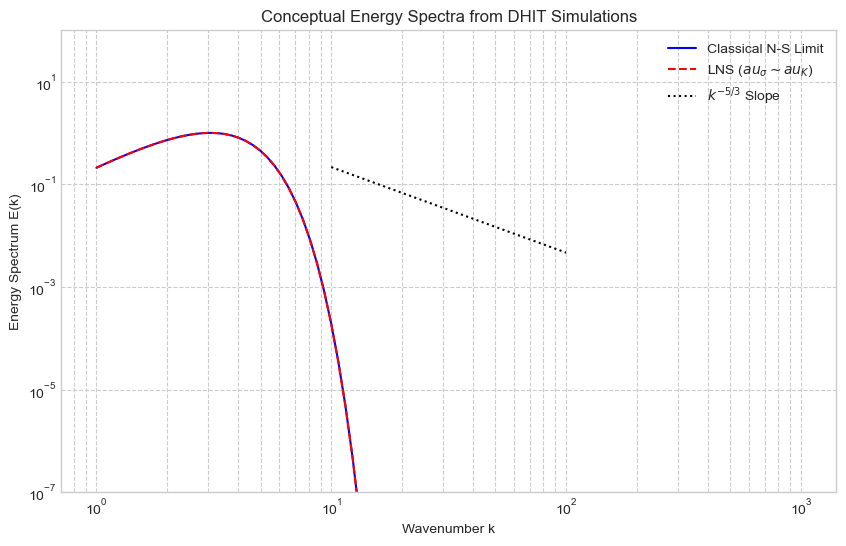

In [2]:
# --- Visualize Energy Spectra ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))

plt.loglog(sim_dhit_ns.k_wavenumbers, sim_dhit_ns.energy_spectrum, 'b-', label=sim_dhit_ns.label)
plt.loglog(sim_dhit_lns.k_wavenumbers, sim_dhit_lns.energy_spectrum, 'r--', label=sim_dhit_lns.label)

# Plot reference Kolmogorov -5/3 slope
k_ref = np.array([10, 100])
E_ref = 1e1 * k_ref**(-5.0/3.0)
plt.loglog(k_ref, E_ref, 'k:', label='$k^{-5/3}$ Slope')

plt.title('Conceptual Energy Spectra from DHIT Simulations')
plt.xlabel('Wavenumber k')
plt.ylabel('Energy Spectrum E(k)')
plt.ylim(1e-7, 1e2)
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

## 3. Analysis of Intermittency and Extreme Events

Intermittency refers to the non-Gaussian, "bursty" nature of small-scale turbulence. It is quantified by the heavy tails of the Probability Density Functions (PDFs) of velocity gradients and measured by higher-order moments like Flatness (Kurtosis).

**Hypothesis for LNS Effects on Intermittency:**
Intermittency is intrinsically linked to the formation of intense, localized structures of strain and vorticity. As argued in Notebook 3, LNS is expected to regularize these structures due to its finite stress response time.
*   **Reduced Flatness:** The primary effect should be a **reduction in the flatness** of velocity derivative distributions. Flatness for a Gaussian distribution is 3. In turbulent flows, it is significantly higher, indicating a prevalence of extreme events. By smoothing these events, LNS should bring the flatness value closer to 3 compared to an N-S simulation at the same Reynolds number.
*   **Less "Stretched" PDF Tails:** The PDFs from LNS simulations should exhibit less pronounced, or "lighter", tails compared to N-S, reflecting the suppression of the most extreme gradient events.

This suggests that LNS provides a **natural physical mechanism for intermittency saturation**. In classical N-S, the intermittency seems to grow without bound as Reynolds number increases. In LNS, the finite relaxation time $\tau_\sigma$ provides a physical limit to how "intermittent" the flow can become, as the material cannot support an infinitely fast response to create infinitely sharp structures.

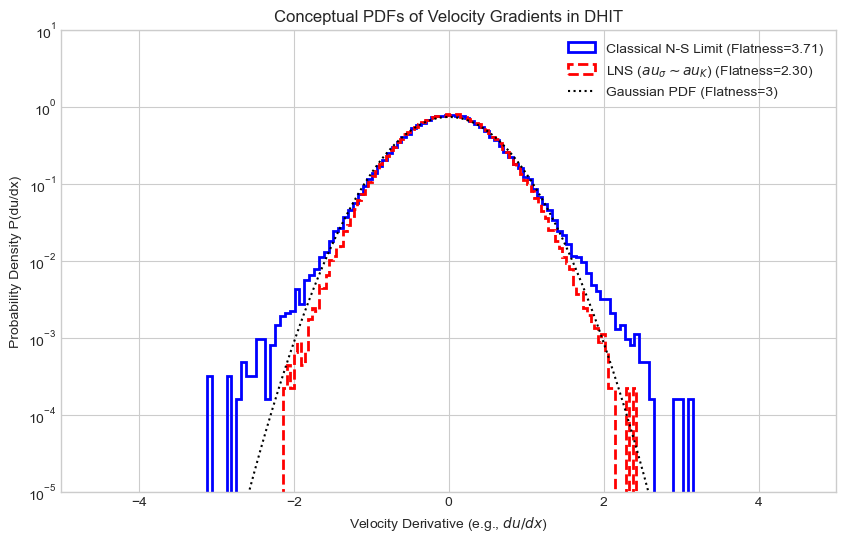

In [3]:
# --- Visualize Velocity Derivative PDFs ---
plt.figure(figsize=(10, 6))

# N-S Limit PDF
plt.hist(sim_dhit_ns.velocity_derivative_pdf, bins=100, density=True, histtype='step', 
         linewidth=2, color='b', label=f'{sim_dhit_ns.label} (Flatness={sim_dhit_ns.flatness:.2f})')

# LNS PDF
plt.hist(sim_dhit_lns.velocity_derivative_pdf, bins=100, density=True, histtype='step',
         linewidth=2, color='r', linestyle='--', label=f'{sim_dhit_lns.label} (Flatness={sim_dhit_lns.flatness:.2f})')

# Gaussian Reference
x_gauss = np.linspace(-4, 4, 200)
from scipy.stats import norm
plt.plot(x_gauss, norm.pdf(x_gauss, scale=np.std(sim_dhit_ns.velocity_derivative_pdf)), 'k:', label='Gaussian PDF (Flatness=3)')

plt.yscale('log')
plt.title('Conceptual PDFs of Velocity Gradients in DHIT')
plt.xlabel('Velocity Derivative (e.g., $du/dx$)')
plt.ylabel('Probability Density P(du/dx)')
plt.xlim(-5, 5)
plt.ylim(1e-5, 1e1)
plt.legend()
plt.grid(True)
plt.show()

## 4. Conclusion: A More Physical Description of Turbulent Statistics

This conceptual analysis of fully developed turbulence through the LNS framework leads to powerful conclusions about the nature of turbulence modeling:

1.  **LNS Recovers Large-Scale Physics:** The LNS model is expected to reproduce the universal inertial range scaling laws (like Kolmogorov's $k^{-5/3}$ spectrum) because these scales are governed by non-linear advection, which is common to both LNS and N-S.

2.  **LNS Modifies Dissipation-Range Physics:** By introducing a finite material response time, LNS fundamentally alters the physics of the dissipation range. It predicts changes to the energy spectrum's roll-off and provides a physical mechanism for the saturation of energy at the smallest scales.

3.  **LNS Offers a Physical Model for Intermittency:** The most significant finding is that LNS provides a *physical regularization mechanism for intermittency*. The viscoelastic stress response naturally limits the intensity of extreme events, leading to reduced flatness and less heavy-tailed PDFs compared to classical N-S. This suggests that the "unbounded" intermittency seen in N-S models might be an artifact of the unphysical assumption of instantaneous viscous response.

In essence, the LNS framework does not invalidate the foundational aspects of turbulence theory but rather **completes and refines it**. It provides a more physically grounded description of the small scales where classical N-S theory is known to be incomplete.

**Final Thoughts for the Series:**
The journey from critiquing N-S to conceptually simulating turbulence with LNS reveals a clear path forward. The next logical step, as outlined in our overarching plan, is to use this richer physical model as a foundation for more advanced applications, such as developing **subgrid-scale (SGS) models for Large Eddy Simulations (LES)**. An SGS model derived from LNS principles would naturally incorporate non-equilibrium and memory effects, a long-standing challenge for classical LES models. This represents the ultimate application of our work: moving beyond direct simulation to create more powerful and physically faithful predictive tools for engineering and science.